# MNIST with Convolutional Networks

In [1]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
import time
import os

In [2]:
tf.__version__

'1.10.0'

In [3]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential

Using TensorFlow backend.


In [4]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [5]:
x_train[:3, :3, :3, 0]

array([[[ 59,  43,  50],
        [ 16,   0,  18],
        [ 25,  16,  49]],

       [[154, 126, 105],
        [140, 145, 125],
        [140, 139, 115]],

       [[255, 253, 253],
        [255, 255, 255],
        [255, 254, 254]]], dtype=uint8)

In [6]:
y_train[:3]

array([[6],
       [9],
       [9]], dtype=uint8)

In [7]:
num_classes = len(np.unique(y_train))
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [8]:
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

In [9]:
Xtr_rows = x_train.reshape(x_train.shape[0], 32 * 32 * 3) # Xtr_rows becomes 50000 x 3072
Xte_rows = x_test.reshape(x_test.shape[0], 32 * 32 * 3) # Xte_rows becomes 10000 x 3072

In [10]:
Xtr_rows[0].shape[0]

3072

In [11]:
Xtr_rows[0][:3]

array([59, 62, 63], dtype=uint8)

In [12]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true) == 9

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Plot image.
        ax.imshow(images[i, :, :, :],
                  interpolation=interpolation)
            
        # Name of the true class.
        cls_true_name = class_names[cls_true[i]]

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [13]:
# Get the first images from the test-set.
sample = x_test[1:10]

# Get the true classes for those images.
cls_true = y_test[1:10].ravel().tolist()

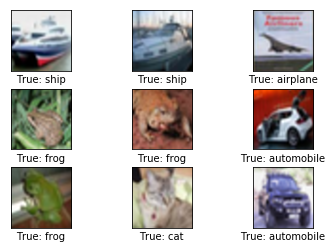

In [14]:
# Plot the images and labels using our helper-function above.
plot_images(images=sample, cls_true=cls_true, smooth=True)


In [123]:
# Process images of this size. Note that this differs from the original CIFAR
# image size of 32 x 32. If one alters this number, then the entire model
# architecture will change and any model would need to be retrained.
IMAGE_SIZE = 24

# Global constants describing the CIFAR-10 data set.
NUM_CLASSES = 10
NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN = 500
NUM_EXAMPLES_PER_EPOCH_FOR_EVAL = 10000

data_dir = os.path.join('data/cifar10_data', 'cifar-10-batches-bin')

In [97]:
# Parameters
learning_rate = 0.001
training_epochs = 3
batch_size = 100
display_step = 1

In [98]:
def read_cifar10(filename_queue):
    """Reads and parses examples from CIFAR10 data files.
    
    Recommendation: if you want N-way read parallelism, call this function
    N times.  This will give you N independent Readers reading different
    files & positions within those files, which will give better mixing of
    examples.
    
    Args:
      filename_queue: A queue of strings with the filenames to read from.
      
    Returns:
      An object representing a single example, with the following fields:
        height: number of rows in the result (32)
        width: number of columns in the result (32)
        depth: number of color channels in the result (3)
        key: a scalar string Tensor describing the filename & record number
          for this example.
        label: an int32 Tensor with the label in the range 0..9.
        uint8image: a [height, width, depth] uint8 Tensor with the image data
    """

    class CIFAR10Record(object):
        pass
    result = CIFAR10Record()

    # Dimensions of the images in the CIFAR-10 dataset.
    # See http://www.cs.toronto.edu/~kriz/cifar.html for a description of the
    # input format.
    label_bytes = 1  # 2 for CIFAR-100
    result.height = 32
    result.width = 32
    result.depth = 3
    image_bytes = result.height * result.width * result.depth
    # Every record consists of a label followed by the image, with a
    # fixed number of bytes for each.
    record_bytes = label_bytes + image_bytes

    # Read a record, getting filenames from the filename_queue.  No
    # header or footer in the CIFAR-10 format, so we leave header_bytes
    # and footer_bytes at their default of 0.
    reader = tf.FixedLengthRecordReader(record_bytes=record_bytes)
    result.key, value = reader.read(filename_queue)

    # Convert from a string to a vector of uint8 that is record_bytes long.
    record_bytes = tf.decode_raw(value, tf.uint8)

    # The first bytes represent the label, which we convert from uint8->int32.
    result.label = tf.cast(
        tf.strided_slice(record_bytes, [0], [label_bytes]), tf.int32)

    # The remaining bytes after the label represent the image, which we reshape
    # from [depth * height * width] to [depth, height, width].
    depth_major = tf.reshape(
        tf.strided_slice(record_bytes, [label_bytes],
                         [label_bytes + image_bytes]),
        [result.depth, result.height, result.width])
    # Convert from [depth, height, width] to [height, width, depth].
    result.uint8image = tf.transpose(depth_major, [1, 2, 0])

    return result

In [99]:
filenames = [os.path.join(data_dir, 'data_batch_%d.bin' % i) for i in range(1, 6)]
for f in filenames:
    if not tf.gfile.Exists(f):
        raise ValueError('Failed to find file: ' + f)

# Create a queue that produces the filenames to read.
filename_queue = tf.train.string_input_producer(filenames)

# Read examples from files in the filename queue.
read_input = read_cifar10(filename_queue)
reshaped_image = tf.cast(read_input.uint8image, tf.float32)

In [100]:
reshaped_image

<tf.Tensor 'Cast_9:0' shape=(32, 32, 3) dtype=float32>

In [101]:
read_input.key

<tf.Tensor 'ReaderReadV2_4:0' shape=() dtype=string>

In [102]:
read_input.label

<tf.Tensor 'Cast_8:0' shape=(?,) dtype=int32>

In [103]:
read_input.uint8image

<tf.Tensor 'transpose_4:0' shape=(32, 32, 3) dtype=uint8>

In [104]:
min_fraction_of_examples_in_queue = 0.4
min_queue_examples = int(NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN * min_fraction_of_examples_in_queue)

## !!!!!

In [105]:
num_preprocess_threads = 16
# Set the shapes of tensors.
read_input.label.set_shape([1])
images, label_batch = tf.train.shuffle_batch(
    [reshaped_image, read_input.label],
    batch_size=batch_size,
    num_threads=num_preprocess_threads,
    capacity=min_queue_examples + 3 * batch_size,
    min_after_dequeue=min_queue_examples)

## !!!!!

In [106]:
label_batch

<tf.Tensor 'shuffle_batch_6:1' shape=(100, 1) dtype=int32>

In [107]:
images

<tf.Tensor 'shuffle_batch_6:0' shape=(100, 32, 32, 3) dtype=float32>

In [108]:
def _generate_image_and_label_batch(image, label, min_queue_examples, batch_size, shuffle):
    """Construct a queued batch of images and labels.
    
    Args:
      image: 3-D Tensor of [height, width, 3] of type.float32.
      label: 1-D Tensor of type.int32
      min_queue_examples: int32, minimum number of samples to retain
      in the queue that provides of batches of examples.
      batch_size: Number of images per batch.
      
    Returns:
      images: Images. 4D tensor of [batch_size, height, width, 3] size.
      labels: Labels. 1D tensor of [batch_size] size.
    """
    # Create a queue that shuffles the examples, and then
    # read 'batch_size' images + labels from the example queue.
    num_preprocess_threads = 16
    if shuffle:
        images, label_batch = tf.train.shuffle_batch(
            [image, label],
            batch_size=batch_size,
            num_threads=num_preprocess_threads,
            capacity=min_queue_examples + 3 * batch_size,
            min_after_dequeue=min_queue_examples)
    else:
        images, label_batch = tf.train.batch(
            [image, label],
            batch_size=batch_size,
            num_threads=num_preprocess_threads,
            capacity=min_queue_examples + 3 * batch_size)

    # Display the training images in the visualizer.
    tf.summary.image('images', images)

    return images, tf.reshape(label_batch, [batch_size])

In [109]:
# Ensure that the random shuffling has good mixing properties.
min_fraction_of_examples_in_queue = 0.4
min_queue_examples = int(NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN * min_fraction_of_examples_in_queue)

In [110]:
_generate_image_and_label_batch(reshaped_image, read_input.label, min_queue_examples, batch_size, shuffle=True)

(<tf.Tensor 'shuffle_batch_7:0' shape=(100, 32, 32, 3) dtype=float32>,
 <tf.Tensor 'Reshape_9:0' shape=(100,) dtype=int32>)

In [111]:
def distorted_inputs(data_dir, batch_size):
    """Construct distorted input for CIFAR training using the Reader ops.
    Args:
      data_dir: Path to the CIFAR-10 data directory.
      batch_size: Number of images per batch.
    Returns:
      images: Images. 4D tensor of [batch_size, IMAGE_SIZE, IMAGE_SIZE, 3] size.
      labels: Labels. 1D tensor of [batch_size] size.
    """

    filenames = [os.path.join(data_dir, 'data_batch_%d.bin' % i) 
                 for i in range(1, 6)]
    for f in filenames:
        if not tf.gfile.Exists(f):
            raise ValueError('Failed to find file: ' + f)

    # Create a queue that produces the filenames to read.
    filename_queue = tf.train.string_input_producer(filenames)

    # Read examples from files in the filename queue.
    read_input = read_cifar10(filename_queue)
    reshaped_image = tf.cast(read_input.uint8image, tf.float32)
    
    height = IMAGE_SIZE
    width = IMAGE_SIZE

    # Image processing for training the network. Note the many random
    # distortions applied to the image.

    # Randomly crop a [height, width] section of the image.
    distorted_image = tf.random_crop(reshaped_image, size=[height, width, 3])

    # Randomly flip the image horizontally.
    distorted_image = tf.image.random_flip_left_right(distorted_image)

    # Because these operations are not commutative, consider randomizing
    # randomize the order their operation.
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
    distorted_image = tf.image.random_contrast(distorted_image, lower=0.2, upper=1.8)

    # Subtract off the mean and divide by the variance of the pixels.
    float_image = tf.image.per_image_standardization(distorted_image)
    
    # Set the shapes of tensors.
    float_image.set_shape([height, width, 3])
    read_input.label.set_shape([1])

    # Ensure that the random shuffling has good mixing properties.
    min_fraction_of_examples_in_queue = 0.4
    min_queue_examples = int(NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN *
                           min_fraction_of_examples_in_queue)
    print ('Filling queue with %d CIFAR images before starting to train. '
           'This will take a few minutes.' % min_queue_examples)

    # Generate a batch of images and labels by building up a queue of examples.

    return _generate_image_and_label_batch(float_image, read_input.label, min_queue_examples, batch_size, shuffle=True)

In [112]:
distorted_inputs(data_dir, batch_size)

Filling queue with 2000 CIFAR images before starting to train. This will take a few minutes.


(<tf.Tensor 'shuffle_batch_8:0' shape=(100, 24, 24, 3) dtype=float32>,
 <tf.Tensor 'Reshape_11:0' shape=(100,) dtype=int32>)

In [113]:
# Architecture
n_hidden_1 = 256
n_hidden_2 = 256

In [114]:
def filter_summary(V, weight_shape):
    ix = weight_shape[0]
    iy = weight_shape[1]
    cx, cy = 8, 8
    V_T = tf.transpose(V, (3, 0, 1, 2))
    tf.summary.image("filters", V_T, max_outputs=64)

In [115]:
def conv2d(input, weight_shape, bias_shape, visualize=False):
    incoming = weight_shape[0] * weight_shape[1] * weight_shape[2]
    weight_init = tf.random_normal_initializer(stddev=(2.0/incoming)**0.5)
    W = tf.get_variable("W", weight_shape, initializer=weight_init)
    if visualize:
        filter_summary(W, weight_shape)
    bias_init = tf.constant_initializer(value=0)
    b = tf.get_variable("b", bias_shape, initializer=bias_init)
    logits = tf.nn.bias_add(tf.nn.conv2d(input, W, strides=[1, 1, 1, 1], padding='SAME'), b)
    return tf.nn.relu(logits)

In [116]:
def max_pool(input, k=2):
    return tf.nn.max_pool(input, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

In [117]:
def layer(input, weight_shape, bias_shape):
    weight_stddev = (2.0/weight_shape[0])**0.5
    w_init = tf.random_normal_initializer(stddev=weight_stddev)
    bias_init = tf.constant_initializer(value=0)
    W = tf.get_variable("W", weight_shape, initializer=w_init)
    b = tf.get_variable("b", bias_shape, initializer=bias_init)
    logits = tf.matmul(input, W) + b
    return tf.nn.relu(logits)

In [118]:
def inference(x, keep_prob):

    with tf.variable_scope("conv_1"):
        conv_1 = conv2d(x, [5, 5, 3, 64], [64], visualize=True)
        pool_1 = max_pool(conv_1)

    with tf.variable_scope("conv_2"):
        conv_2 = conv2d(pool_1, [5, 5, 64, 64], [64])
        pool_2 = max_pool(conv_2)

    with tf.variable_scope("fc_1"):

        dim = 1
        for d in pool_2.get_shape()[1:].as_list():
            dim *= d

        pool_2_flat = tf.reshape(pool_2, [-1, dim])
        fc_1 = layer(pool_2_flat, [dim, 384], [384])
        
        # apply dropout
        fc_1_drop = tf.nn.dropout(fc_1, keep_prob)

    with tf.variable_scope("fc_2"):

        fc_2 = layer(fc_1_drop, [384, 192], [192])
        
        # apply dropout
        fc_2_drop = tf.nn.dropout(fc_2, keep_prob)

    with tf.variable_scope("output"):
        output = layer(fc_2_drop, [192, 10], [10])

    return output

In [119]:
def loss(output, y):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=output, labels=tf.cast(y, tf.int64))
    loss = tf.reduce_mean(xentropy)    
    return loss

In [120]:
def training(cost, global_step):
    tf.summary.scalar("cost", cost)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_op = optimizer.minimize(cost, global_step=global_step)
    return train_op

In [121]:
def evaluate(output, y):
    correct_prediction = tf.equal(tf.cast(tf.argmax(output, 1), dtype=tf.int32), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar("validation error", (1.0 - accuracy))
    return accuracy

In [124]:
if __name__ == '__main__':

    with tf.device("/gpu:0"):

        with tf.Graph().as_default():

            with tf.variable_scope("cifar_conv_model"):

                x = tf.placeholder("float", [None, 24, 24, 3])
                y = tf.placeholder("int32", [None])
                keep_prob = tf.placeholder(tf.float32) # dropout probability

                distorted_images, distorted_labels = distorted_inputs(data_dir, batch_size)
                #val_images, val_labels = inputs()

                output = inference(x, keep_prob)

                cost = loss(output, y)

                global_step = tf.Variable(0, name='global_step', trainable=False)

                train_op = training(cost, global_step)

                eval_op = evaluate(output, y)

                summary_op = tf.summary.merge_all()

                saver = tf.train.Saver()

                sess = tf.Session()

                summary_writer = tf.summary.FileWriter("conv_cifar_logs/", graph_def=sess.graph_def)

                
                init_op = tf.global_variables_initializer()

                sess.run(init_op)
                
                tf.train.start_queue_runners(sess=sess)

                # Training cycle
                for epoch in range(training_epochs):
                    
                    avg_cost = 0.
                    total_batch = int(NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN/batch_size)
                    # Loop over all batches
                    for i in range(total_batch):
                        # Fit training using batch data
                        
                        train_x, train_y = sess.run([distorted_images, distorted_labels])
                        
                        _, new_cost = sess.run([train_op, cost], feed_dict={x: train_x, y: train_y, keep_prob: 0.5})                                            
                        # Compute average loss
                        avg_cost += new_cost/total_batch
                        print("Epoch %d, minibatch %d of %d. Cost = %0.4f." %(epoch, i, total_batch, new_cost))
                             
                    # Display logs per epoch step
                    if epoch % display_step == 0:
                        print("Epoch:", '%04d' % (epoch+1), "cost =", "{:.9f}".format(avg_cost))  
                        
                print("Optimization Finished!")
                        

Filling queue with 200 CIFAR images before starting to train. This will take a few minutes.
INFO:tensorflow:Summary name validation error is illegal; using validation_error instead.
Epoch 0, minibatch 0 of 5. Cost = 4.8403.
Epoch 0, minibatch 1 of 5. Cost = 3.0491.
Epoch 0, minibatch 2 of 5. Cost = 2.6546.
Epoch 0, minibatch 3 of 5. Cost = 2.4192.
Epoch 0, minibatch 4 of 5. Cost = 2.3604.
Epoch: 0001 cost = 3.064721394
Epoch 1, minibatch 0 of 5. Cost = 2.3633.
Epoch 1, minibatch 1 of 5. Cost = 2.3212.
Epoch 1, minibatch 2 of 5. Cost = 2.3396.
Epoch 1, minibatch 3 of 5. Cost = 2.3080.
Epoch 1, minibatch 4 of 5. Cost = 2.3270.
Epoch: 0002 cost = 2.331815386
Epoch 2, minibatch 0 of 5. Cost = 2.3115.
Epoch 2, minibatch 1 of 5. Cost = 2.2715.
Epoch 2, minibatch 2 of 5. Cost = 2.3259.
Epoch 2, minibatch 3 of 5. Cost = 2.3083.
Epoch 2, minibatch 4 of 5. Cost = 2.3068.
Epoch: 0003 cost = 2.304784441
Optimization Finished!
